In [3]:
!pip install rasterio albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.9 MB/s eta 0:00:00:00:0100:01


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import albumentations as A
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, Rotate, Resize, Normalize, Compose,RandomRotate90, GaussNoise
)
from albumentations.pytorch import ToTensorV2
import rasterio

In [5]:
dataset_path = "/kaggle/input/cloud-masking-dataset/content/train"
data_dir = os.path.join(dataset_path, 'data')
mask_dir = os.path.join(dataset_path, 'masks')
image_filenames = sorted([f for f in os.listdir(data_dir)])

train_filenames, val_filenames = train_test_split(
    image_filenames, 
    test_size=0.2, 
    random_state=42
)

print(f"Total images: {len(image_filenames)}")
print(f"Training set: {len(train_filenames)}")
print(f"Validation set: {len(val_filenames)}")

Total images: 10573
Training set: 8458
Validation set: 2115


In [6]:
augmented_image_dir = '/kaggle/working/augmented/images'
augmented_mask_dir = '/kaggle/working/augmented/masks'

os.makedirs(augmented_image_dir, exist_ok=True)
os.makedirs(augmented_mask_dir, exist_ok=True)

# Augmentation pipeline
augmentation = Compose([
    Resize(128, 128),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
])

AUG_PER_IMAGE = 10

def offline_augment_and_save(image_dir, mask_dir, image_files):
    for file_name in tqdm(image_files):
        img_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)

        # Read 4-channel image
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)
            image = np.transpose(image, (1, 2, 0))  # [H, W, 4]
            image = image[:, :, [2, 3]]             # Keep only bands 3 and 4 → shape [H, W, 2]

        # Read mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)  # [H, W]

        for i in range(AUG_PER_IMAGE):
            augmented = augmentation(image=image, mask=mask)
            aug_image = augmented['image']
            aug_mask = augmented['mask']

            # Convert back to [C, H, W] for saving with rasterio
            aug_image_np = np.transpose(aug_image, (2, 0, 1)).astype(np.float32)
            aug_mask_np = aug_mask.astype(np.uint8)

            # Save image
            image_aug_path = os.path.join(augmented_image_dir, f"{file_name.replace('.tif', '')}_aug{i}.tif")
            with rasterio.open(
                image_aug_path, 'w',
                driver='GTiff',
                height=aug_image_np.shape[1],
                width=aug_image_np.shape[2],
                count=2,
                dtype=aug_image_np.dtype
            ) as dst:
                dst.write(aug_image_np)

            # Save mask
            mask_aug_path = os.path.join(augmented_mask_dir, f"{file_name.replace('.tif', '')}_aug{i}.tif")
            with rasterio.open(
                mask_aug_path, 'w',
                driver='GTiff',
                height=aug_mask_np.shape[0],
                width=aug_mask_np.shape[1],
                count=1,
                dtype=aug_mask_np.dtype
            ) as dst:
                dst.write(aug_mask_np, 1)

In [7]:
offline_augment_and_save(
    image_dir=data_dir,
    mask_dir=mask_dir,
    image_files=train_filenames,
)
augmented_image_dir = '/kaggle/working/augmented/images'
augmented_mask_dir = '/kaggle/working/augmented/masks'
augmented_filenames = sorted([f for f in os.listdir(augmented_image_dir)])

  0%|          | 0/8458 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
100%|██████████| 8458/8458 [14:50<00:00,  9.49it/s]


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import tifffile as tiff
import os
from tqdm import tqdm

class CloudDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.filenames = filenames
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)
        image = tiff.imread(image_path)  # Shape: [H, W, C]
        mask = tiff.imread(mask_path)    # Shape: [H, W]
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # [C, H, W]
        mask = torch.from_numpy(mask).unsqueeze(0).float()         # [1, H, W]
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

augmented_filenames = [f for f in os.listdir(augmented_image_dir) if f.endswith('.tif')]

# Create dataset
train_dataset = CloudDataset(
    augmented_image_dir,
    augmented_mask_dir,
    augmented_filenames
)
# Create train dataset
train_dataset = CloudDataset(
    augmented_image_dir,
    augmented_mask_dir,
    augmented_filenames
)

# Create data loader for efficient batching
BATCH_SIZE = 32
NUM_WORKERS = 4  # Adjust based on your CPU cores
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True  # Faster data transfer to GPU
)

# Verification
print(f"Total augmented samples: {len(train_dataset)}")
for images, masks in train_loader:
    print(f"Batch images shape: {images.shape}")  # [B, C, H, W]
    print(f"Batch masks shape: {masks.shape}")    # [B, 1, H, W]
    break  # Just show first batch



Total augmented samples: 84580
Batch images shape: torch.Size([32, 2, 128, 128])
Batch masks shape: torch.Size([32, 1, 128, 128])


In [9]:
# Create test dataset
# Add this transform to your dataset
from torchvision.transforms import Lambda 
channel_transform = Lambda(lambda x: x[-2:, :, :])  # Keep last 2 channels

val_dataset = CloudDataset(
    data_dir,
    mask_dir,
    val_filenames,
    transform=channel_transform  # Add to your existing transforms
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True 
)

print(f"Total validation samples: {len(val_dataset)}")
for images, masks in val_loader:
    print(f"Batch images shape: {images.shape}")  # [B, C, H, W]
    print(f"Batch masks shape: {masks.shape}")    # [B, 1, H, W]
    break  # Just show first batch

Total validation samples: 2115
Batch images shape: torch.Size([32, 2, 512, 512])
Batch masks shape: torch.Size([32, 1, 512, 512])


In [10]:
def compute_class_priors_from_loader(data_loader):
    no_cloud_count = 0
    cloud_count = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Calculating class priors"):
            masks = masks.to(device)
            cloud_count += torch.sum(masks == 1).item()
            no_cloud_count += torch.sum(masks == 0).item()
    
    total_pixels = cloud_count + no_cloud_count
    p_no_cloud = no_cloud_count / total_pixels
    p_cloud = cloud_count / total_pixels
    return p_no_cloud, p_cloud

prior_no_cloud, prior_cloud = compute_class_priors_from_loader(train_loader)
print(f"P(No Cloud): {prior_no_cloud:.4f}")
print(f"P(Cloud): {prior_cloud:.4f}")
# priot_cloud = 0.6573

Calculating class priors: 100%|██████████| 2644/2644 [01:42<00:00, 25.78it/s]

P(No Cloud): 0.3789
P(Cloud): 0.6211


In [11]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

def compute_histogram_gpu(data_loader, class_value, bins=20, smooth_sigma=0.9):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    global_min = torch.tensor([float('inf')]*2, device=device)
    global_max = torch.tensor([-float('inf')]*2, device=device)
    
    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)  # [B, 2, H, W]
            masks = masks.to(device)    # [B, 1, H, W]
            
            # Create mask for selected class
            mask = (masks == class_value).float()
            
            # Apply mask and find non-zero values
            masked_pixels = images * mask  # [B, 2, H, W]
            non_zero = masked_pixels.abs().sum(dim=1) > 0  # [B, H, W]
            
            if non_zero.any():
                valid_pixels = masked_pixels.permute(0, 2, 3, 1)[non_zero]  # [N, 2]
                
                current_min, _ = valid_pixels.min(dim=0)
                current_max, _ = valid_pixels.max(dim=0)
                
                global_min = torch.minimum(global_min, current_min)
                global_max = torch.maximum(global_max, current_max)
    
    # Calculate bin edges
    ranges = [
        (global_min[0].item(), global_max[0].item()),
        (global_min[1].item(), global_max[1].item())
    ]
    
    # Initialize histogram on CPU
    hist = np.zeros((bins, bins))
    bin_edges = [np.linspace(r[0], r[1], bins+1) for r in ranges]
    
    # Second pass: compute histogram
    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc=f"Class {class_value}"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Apply mask
            masked_pixels = images * (masks == class_value).float()
            
            # Get valid pixels and move to CPU
            valid_pixels = masked_pixels.permute(0, 2, 3, 1).reshape(-1, 2)
            valid_pixels = valid_pixels[valid_pixels.abs().sum(dim=1) > 0].cpu().numpy()
            
            if len(valid_pixels) > 0:
                batch_hist, _ = np.histogramdd(valid_pixels, bins=bin_edges)
                hist += batch_hist
    
    # Apply smoothing and normalize
    if smooth_sigma > 0:
        hist = gaussian_filter(hist, sigma=smooth_sigma)
    hist = hist / (hist.sum() + 1e-10)
    
    return hist, bin_edges


print("Computing histograms...")
hist_cloud, edges = compute_histogram_gpu(train_loader, class_value=1)
hist_noncloud, _ = compute_histogram_gpu(train_loader, class_value=0)

Computing histograms...


Class 0: 100%|██████████| 2644/2644 [00:50<00:00, 51.90it/s]


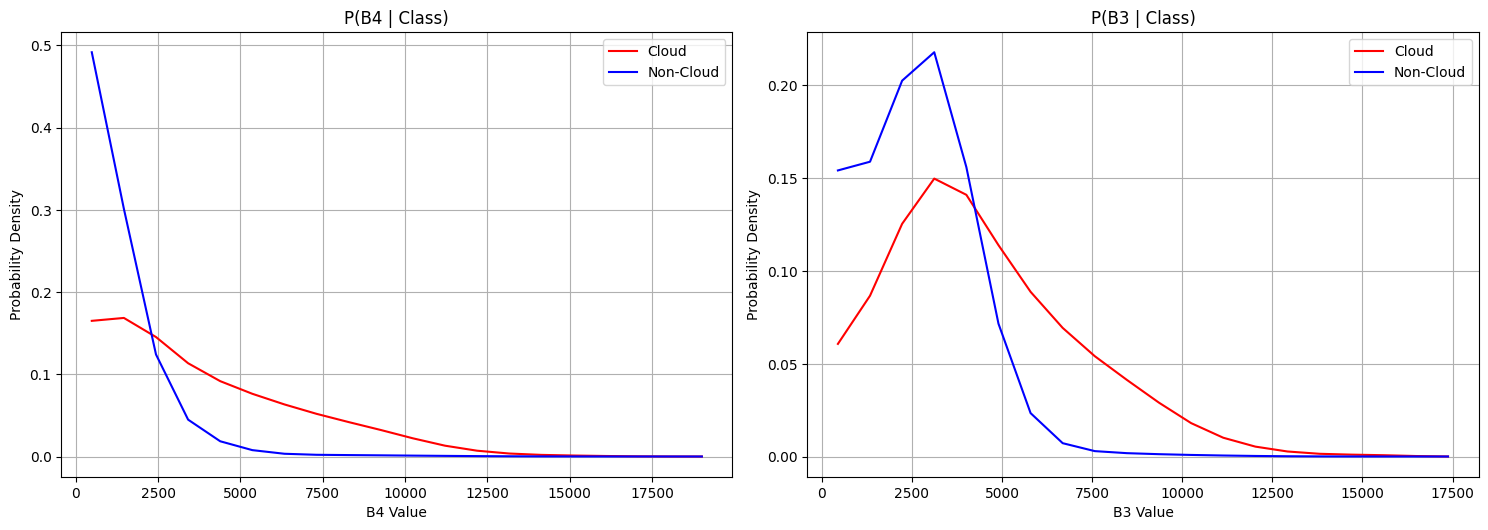

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_all_conditional_probs_gpu(hist, edges):
    hist_tensor = torch.from_numpy(hist).cuda().float()
    probs = []
    centers = []
    
    for dim in range(2):
        # Sum along the other dimension (GPU-accelerated)
        if dim == 0:
            prob = torch.sum(hist_tensor, dim=1)  # Sum over B3
        else:
            prob = torch.sum(hist_tensor, dim=0)  # Sum over B4
        
        # Calculate bin centers (still on CPU)
        band_edges = edges[dim]
        band_centers = (band_edges[:-1] + band_edges[1:]) / 2
        
        # Move probabilities back to CPU for plotting
        probs.append(prob.cpu().numpy())
        centers.append(band_centers)

        
    return probs, centers

p_cloud, centers = compute_all_conditional_probs_gpu(hist_cloud, edges)
p_noncloud, _ = compute_all_conditional_probs_gpu(hist_noncloud, edges)
band_names = ['B4', 'B3']
plt.figure(figsize=(15, 10))
for i in range(2):
    plt.subplot(2, 2, i+1)
    plt.plot(centers[i], p_cloud[i], 'r-', label='Cloud')
    plt.plot(centers[i], p_noncloud[i], 'b-', label='Non-Cloud')
    plt.xlabel(f'{band_names[i]} Value')
    plt.ylabel('Probability Density')
    plt.title(f'P({band_names[i]} | Class)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
import torch
import numpy as np

def bayesian_classifier_gpu(image_batch, p_cloud, p_noncloud, centers, prior_cloud, prob_maps=False):

    device = image_batch.device if isinstance(image_batch, torch.Tensor) else 'cpu'
    if not isinstance(image_batch, torch.Tensor):
        image_batch = torch.from_numpy(image_batch).float()
    pixels = image_batch.permute(0, 2, 3, 1).reshape(-1, 2)  # Flatten to (B*H*W, 2)
    pixels = pixels.contiguous().to(device)
    
    # Convert probability tables to tensors on the correct device
    p_cloud = [p.to(device) if isinstance(p, torch.Tensor) else torch.from_numpy(p).float().to(device) for p in p_cloud]
    p_noncloud = [p.to(device) if isinstance(p, torch.Tensor) else torch.from_numpy(p).float().to(device) for p in p_noncloud]
    
    # Compute bin indices for each dimension
    bin_indices = []
    for dim in range(2):
        # Create edges that cover the full range
        min_val = centers[dim][0] - 1e-6
        max_val = centers[dim][-1] + 1e-6
        edges = torch.linspace(min_val, max_val, len(p_cloud[dim])+1, device=device)
        
        # Find bin indices and clamp to valid range
        indices = torch.bucketize(pixels[:, dim], edges) - 1
        indices = torch.clamp(indices, 0, len(p_cloud[dim])-1)
        bin_indices.append(indices)
    
    # Compute likelihoods
    like_cloud = p_cloud[0][bin_indices[0]] * p_cloud[1][bin_indices[1]]
    like_noncloud = p_noncloud[0][bin_indices[0]] * p_noncloud[1][bin_indices[1]]
    
    # Compute posterior probabilities
    numerator = like_cloud * prior_cloud
    denominator = numerator + like_noncloud * (1 - prior_cloud)
    posterior = numerator / (denominator + 1e-12)  # Add epsilon for numerical stability
    
    # Reshape to original batch dimensions
    # Batch images shape: torch.Size([32, 2, 128, 128])
    B, H, W = image_batch.shape[0], image_batch.shape[2], image_batch.shape[3]
    posterior = posterior.reshape(B, H, W)
    classification = (posterior > 0.5).float()
    
    if prob_maps:
        return classification, posterior
    return classification, None

  0%|          | 0/67 [00:00<?, ?it/s]

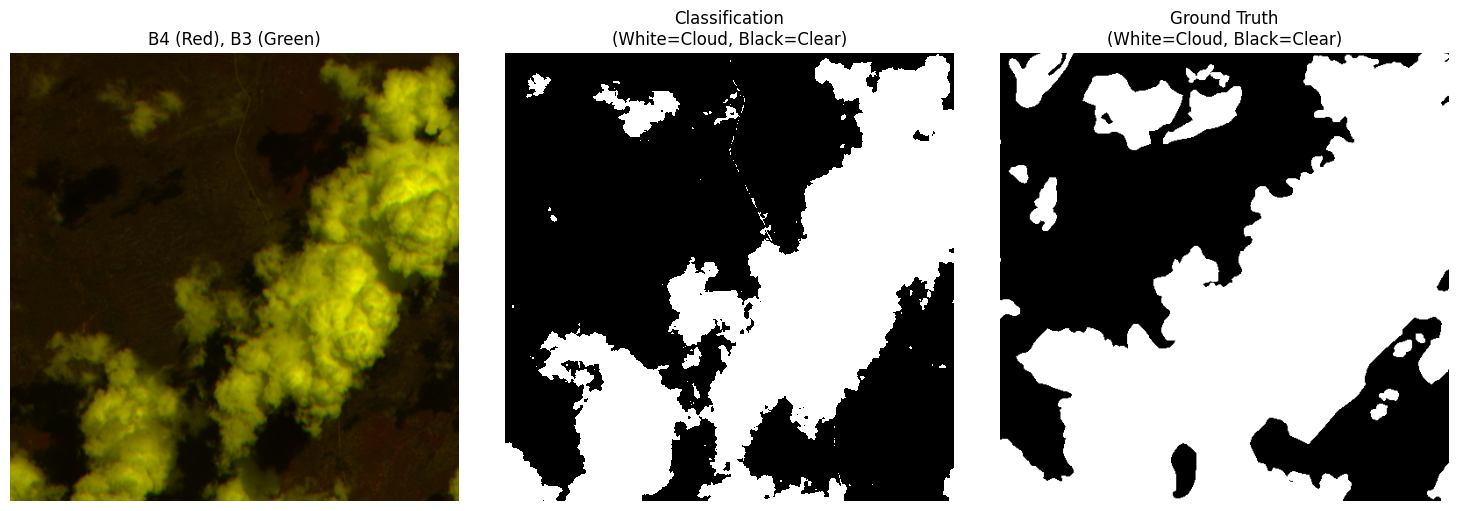

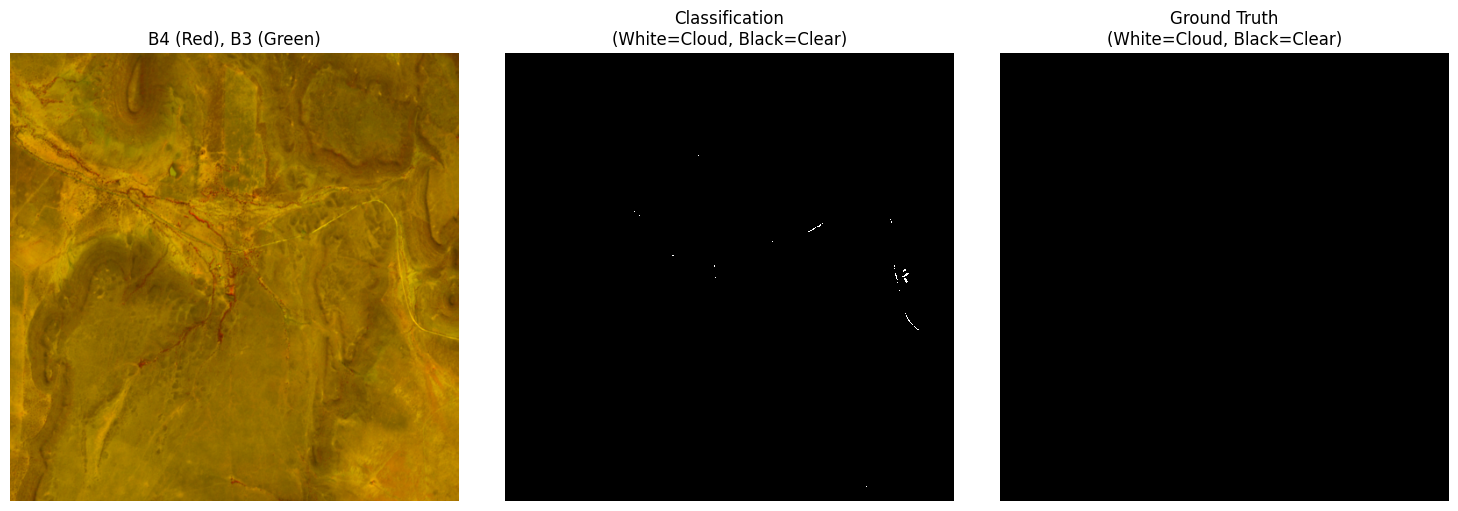

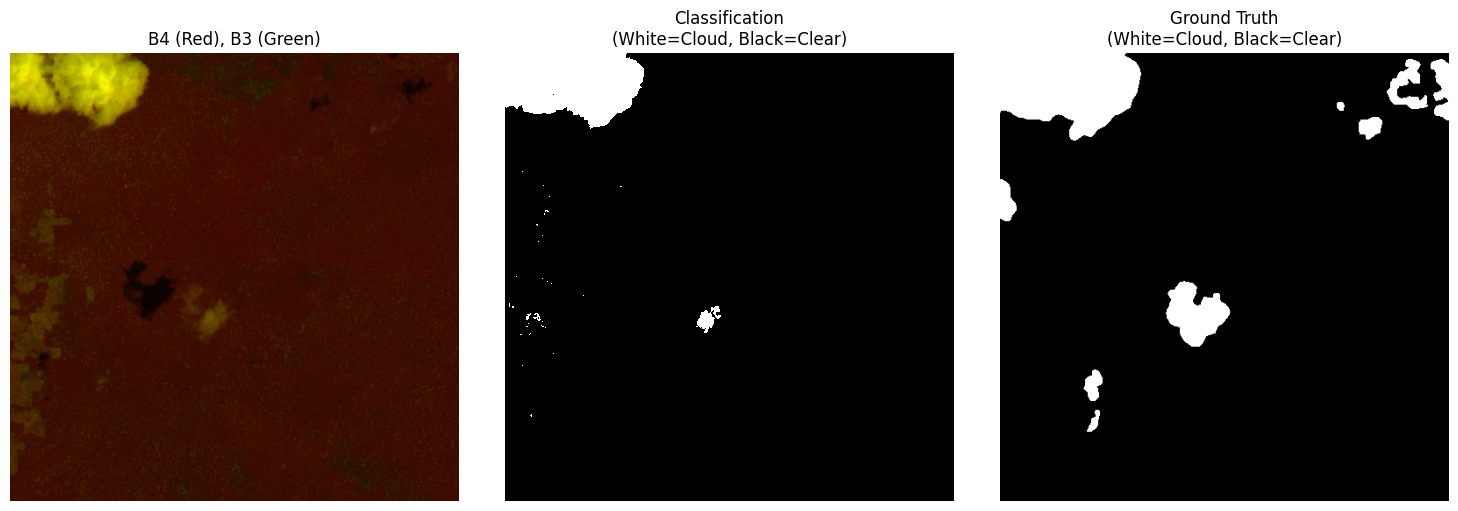

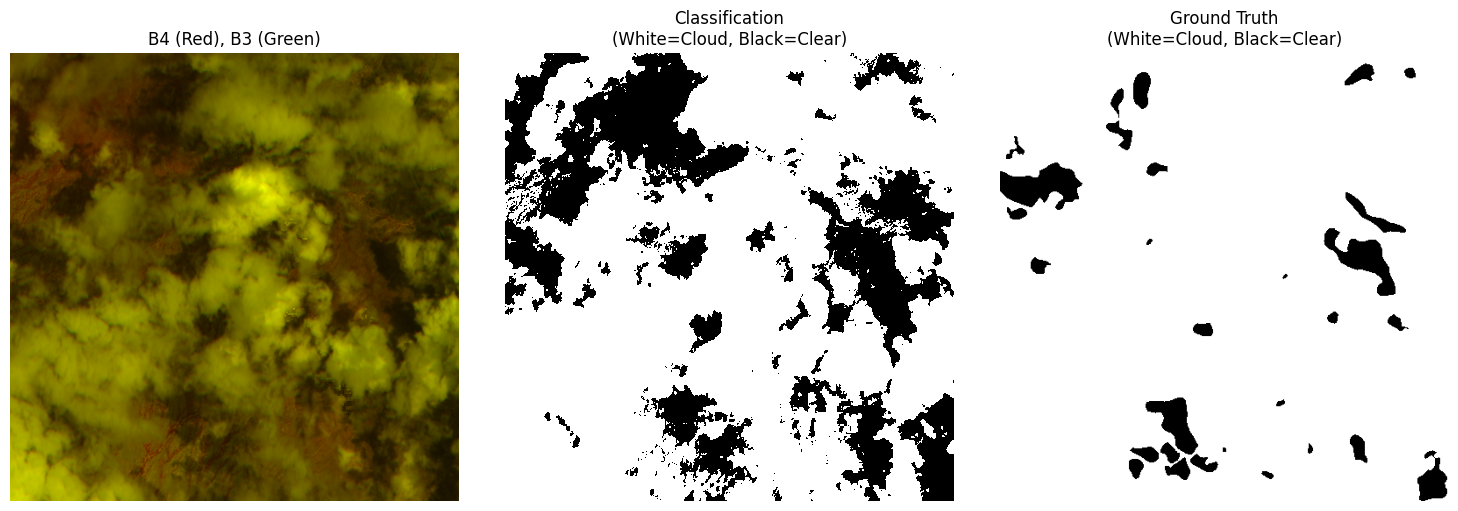

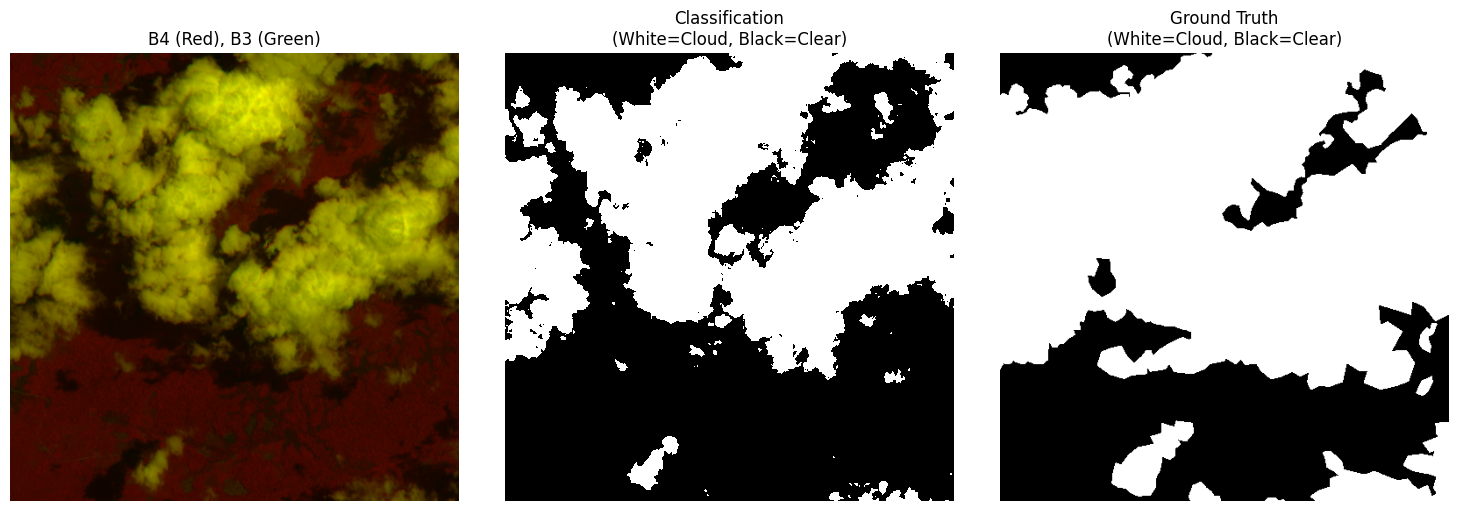

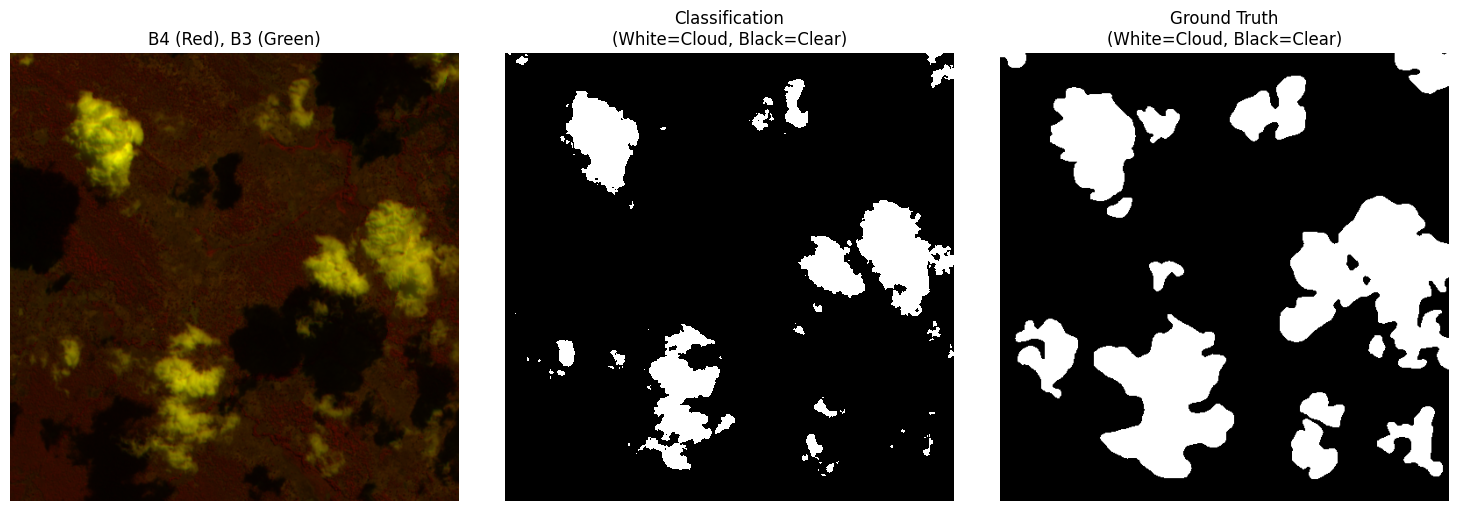

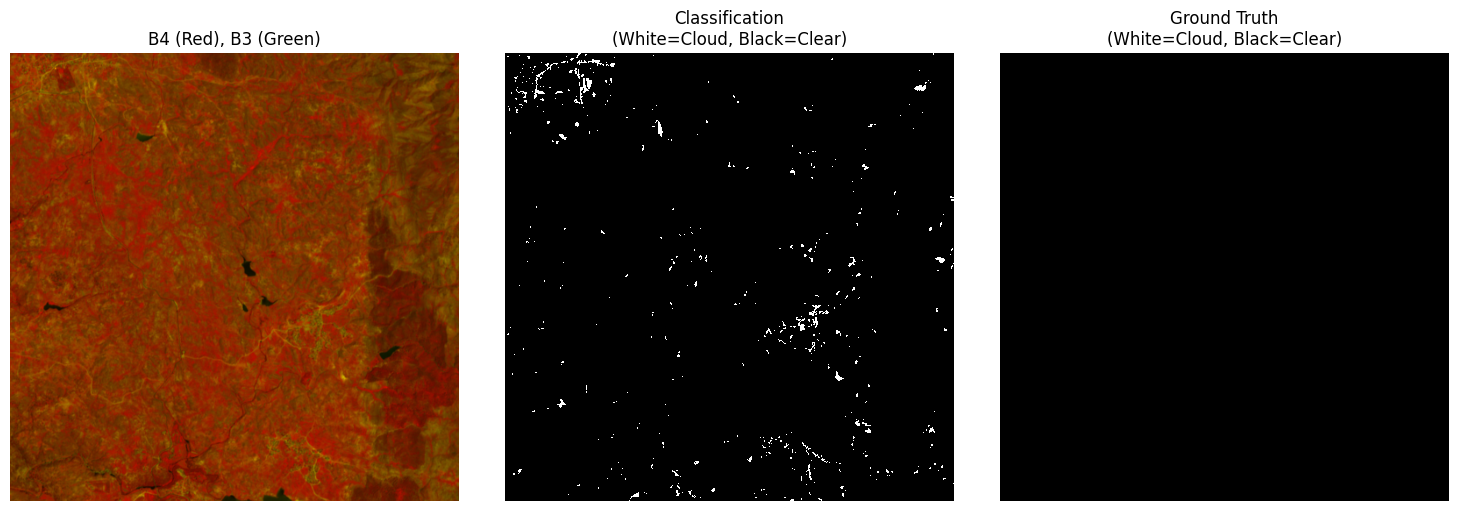

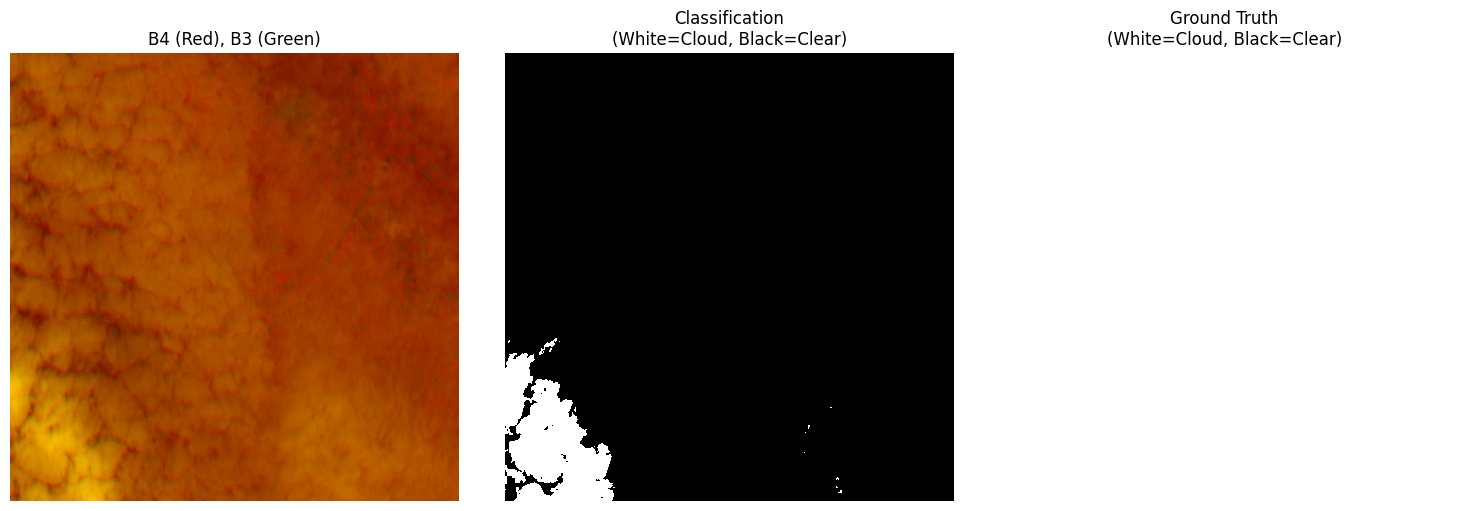

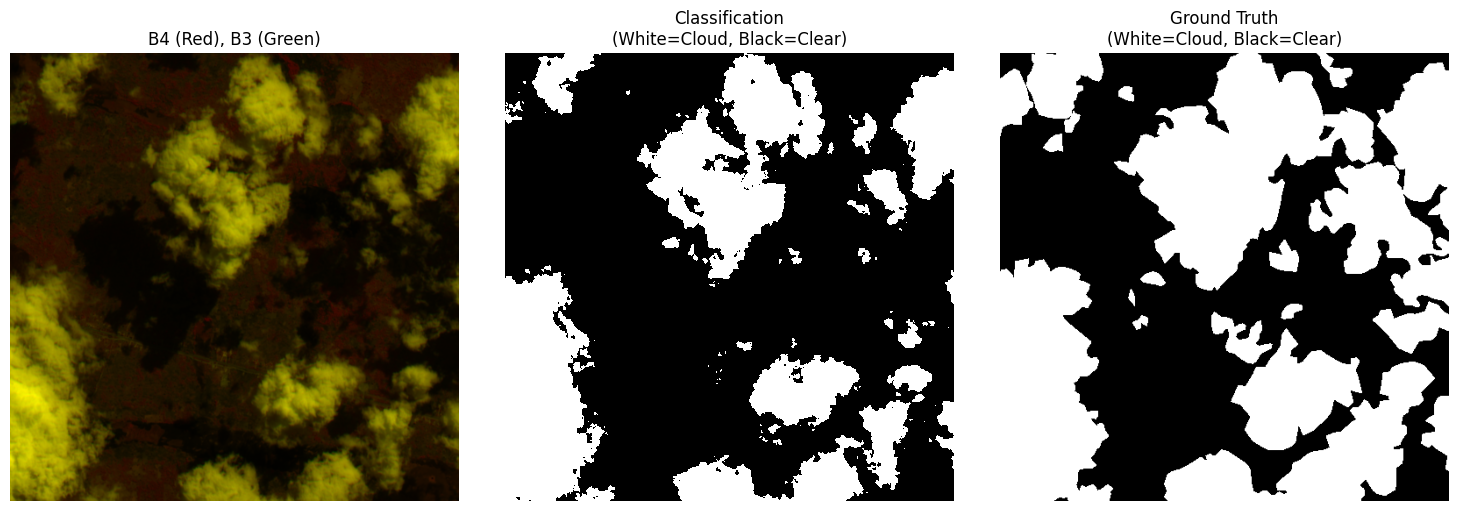

  0%|          | 0/67 [00:05<?, ?it/s]


KeyboardInterrupt: 

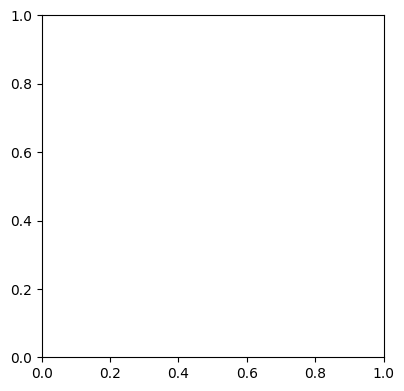

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def dice_coefficient_gpu(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten().float()
    y_pred_f = y_pred.flatten().float()
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)


def visualize_results(test_image, test_mask, classification_map, prob_map=None):
    plt.figure(figsize=(15, 5))
    if isinstance(test_image, torch.Tensor):
        test_image = test_image.cpu().numpy()
    if isinstance(test_mask, torch.Tensor):
        test_mask = test_mask.cpu().numpy()
    if isinstance(classification_map, torch.Tensor):
        classification_map = classification_map.cpu().numpy()
    plt.subplot(1, 3, 1)
    
    vis_image = np.zeros((test_image.shape[0], test_image.shape[1], 3))
    vis_image[:, :, 0] = test_image[:, :, 1]  # B4 -> Red
    vis_image[:, :, 1] = test_image[:, :, 0]  # B3 -> Green
    vis_image = (vis_image - vis_image.min()) / (vis_image.max() - vis_image.min() + 1e-8)
    plt.imshow(vis_image)
    plt.title('B4 (Red), B3 (Green)')
    plt.axis('off')

    
    plt.subplot(1, 3, 2)
    plt.imshow(classification_map, cmap='gray', interpolation='nearest')
    plt.title('Classification\n(White=Cloud, Black=Clear)')
    plt.axis('off')

    # 3. Ground Truth Mask
    plt.subplot(1, 3, 3)
    plt.imshow(test_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Ground Truth\n(White=Cloud, Black=Clear)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_validation_set(val_loader, classifier_args, num_samples=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    classifier_args_gpu = {
        'p_cloud': torch.from_numpy(classifier_args['p_cloud']).float().to(device),
        'p_noncloud': torch.from_numpy(classifier_args['p_noncloud']).float().to(device),
        'centers': classifier_args['centers'],
        'prior_cloud': torch.tensor(classifier_args['prior_cloud']).float().to(device)
    }
    
    with torch.no_grad():
         for images, masks in tqdm(val_loader):
            images = images.to(device)
            masks = masks.to(device)
            classification_maps, _ = bayesian_classifier_gpu(images, **classifier_args_gpu)
            for i in range(images.shape[0]):
                dice = dice_coefficient_gpu(masks[i], classification_maps[i])
                # print(f"Dice Coefficient: {dice:.4f} for image {i}")
                img_np = images[i].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]
                mask_np = masks[i].squeeze().cpu().numpy()
                pred_np = classification_maps[i].cpu().numpy()
                
                visualize_results(img_np, mask_np, pred_np)



classifier_args = {
    'p_cloud': np.asarray(p_cloud),
    'p_noncloud':  np.asarray(p_noncloud),
    'centers': centers,
    'prior_cloud': prior_cloud
}
visualize_validation_set(val_loader, classifier_args, 3)

In [21]:
import torch
import numpy as np
from tqdm import tqdm

def evaluate_validation_set_gpu(val_loader, classifier_args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    classifier_args_gpu = {
        'p_cloud': torch.from_numpy(classifier_args['p_cloud']).float().to(device),
        'p_noncloud': torch.from_numpy(classifier_args['p_noncloud']).float().to(device),
        'centers': classifier_args['centers'],
        'prior_cloud': torch.tensor(classifier_args['prior_cloud']).float().to(device)
    }
    
    dice_scores = []
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Evaluating"):
            images = images.to(device)  # [B, 2, H, W]
            masks = masks.to(device)    # [B, 1, H, W]
        
            pred_maps, _ = bayesian_classifier_gpu(images, **classifier_args_gpu)
            
            # Compute Dice for each image in batch
            for i in range(images.shape[0]):
                dice = dice_coefficient_gpu(masks[i], pred_maps[i])
                dice_scores.append(dice.cpu().item())
    
    dice_scores = np.array(dice_scores)

    return dice_scores
dice_scores=evaluate_validation_set_gpu(val_loader, classifier_args)
print("\n=== Evaluation Summary ===")
print(f"Mean Dice: {dice_scores.mean():.4f}")
print(f"Std Dice: {dice_scores.std():.4f}")
print(f"Min Dice: {dice_scores.min():.4f}")
print(f"Max Dice: {dice_scores.max():.4f}")
print(f"Evaluated {len(dice_scores)} images")

Evaluating: 100%|██████████| 67/67 [00:08<00:00,  8.10it/s]


=== Evaluation Summary ===
Mean Dice: 0.5692
Std Dice: 0.3424
Min Dice: 0.0000
Max Dice: 1.0000
Evaluated 2115 images


In [ ]:
'''
=== Evaluation Summary ===
Mean Dice: 0.5692
Std Dice: 0.3424
Min Dice: 0.0000
Max Dice: 1.0000
Evaluated 2115 images
'''